## Packages and requirements

In [5]:
# Major builtin libraries
import os
import gc
import time
import random
import typing as t
from copy import deepcopy
from functools import reduce
from collections import defaultdict
from IPython.display import clear_output

In [6]:
import warnings  # If you want to disable warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [7]:
# Classic packages for data manipulation and visualization
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

In [8]:
# Basic PyTorch
import torch
import torch.nn as nn
# import torch.optim as optim  # Optimization algorithms and dynamic learning rate adjusting
import torch.nn.functional as F
# from torch.nn.modules.loss import _Loss  # For writing a custom Loss function
# from torch.utils.data import DataLoader, Dataset  # For custom data presentation

In [9]:
# Utils
import joblib  # Pipelining, pickling (dump/load), parallel processing
from tqdm import tqdm  # Progress bar for training process
from tempfile import TemporaryDirectory

# Classic ML tools
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold  # Cross-Validation

In [10]:
# ML Metrics
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# from torchmetrics.classification import MulticlassF1Score, F1Score # F1 metric for multiclass

In [11]:
# Torch Computer Vision tools for images processing
import cv2
from ultralytics import YOLO
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
# from torchvision import models  # Pretrained models

In [12]:
# Albumentations is an OS library for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# import torchvision.transforms as T  # We can use torch augmentations instead

In [13]:
# Output text colorizing
from colorama import Back, Style

def print_highlighted(text: str, bgcolor=Back.YELLOW) -> None:
    """
    Function to print a text with colored background.
    """
    print(bgcolor + text + Style.RESET_ALL)

## Configuration

In [14]:
CONFIG = {
    "seed": 2306,
    # "epochs": 20,
    "image_dimension": 256,  # Depends on pretrained model used
    "model_name": "SiamesePerceptron",  # Pretrained model we will use
    "embedding_size": 512,  # Embedding output size
    # "train_batch_size": 200,
    # "val_batch_size": 400,
    "learning_rate": 1e-3,
    "min_lr": 1e-8,
    "min_loss_delta": 1e-7, # To stop training on plateau
    "weight_decay": 1e-7,

}

In [15]:
class Config:
    """
    Class to simplify access to Config: not dict but object with attributes
    """
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = Config(config_dict=CONFIG)
del CONFIG # We can delete is

In [16]:
def set_seed(seed=42):
    """
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(seed=config.seed)

In [17]:
# config.repo = 'car-brands/'  # dataset name on Kaggle
config.repo = 'data/'  # dataset name on local device
# config.repo = 'car_brand_detection/'  # Google Collab

# config.root = '/kaggle/input/' + config.repo
# config.root = 'drive/MyDrive/' + config.repo
config.root = '../'  + config.repo

config.data_path = config.root + 'embeddings_and_labels.csv'
config.test_images_path = config.root + 'images/test'
config.test_labels = config.root + 'test_labels.csv'

config.mlp_model_path = 'saved_instances/SiamesePerceptron.pth'
config.embedding_model_path = 'saved_instances/ArcFace_mobilenet_v2.pth'
config.yolo_model_path = "saved_instances/yolov8m-seg.pt"
config.arcface_classifier = 'saved_instances/Trained_ArcLoss_parameters.pth'
config.neighbors_model = "saved_instances/KNeighbors_model.pkl"
config.label_encoder = "saved_instances/test_LEncoder.pkl"

In [18]:
with open(config.label_encoder, "rb") as fp:
    decoder: LabelEncoder = joblib.load(fp)

In [19]:
config.labels = torch.tensor(decoder.transform(decoder.classes_))

In [20]:
config.num_of_classes = len(decoder.classes_)

In [32]:
config.data_path = config.root + 'embeddings_and_labels.csv'
df = pd.read_csv(config.data_path)
embeddings_bag = torch.tensor(df[(df.columns[:-1])].to_numpy())
labels_bag = torch.tensor(decoder.transform(df[df.columns[-1]].to_numpy()))

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_size, num_classes, margin=0.5, scale=64):
        super().__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        self.weight = nn.Parameter(torch.ones([num_classes, embedding_size], dtype=torch.float32, device=device))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings):
        # Normalize the embeddings and weights
        return F.softmax(F.linear(embeddings, self.weight), dim=1)
        embeddings = F.normalize(embeddings, dim=1)
        weights = F.normalize(self.weight, dim=1)

        # Compute the cosine similarity between embeddings and weights
        cosine = F.linear(embeddings, weights)

        # Calculate the theta (angle) values for each class
        theta = torch.acos(torch.clip(cosine, -1 + 1e-7, 1 - 1e-7))

        # Apply the ArcFace margin and calculate logits
        target_logits = torch.cos(theta + self.margin)

        logits = self.scale * target_logits
        probabilities = F.softmax(logits, dim=1)
        return probabilities

    # def forward(self, embeddings, labels):
    #     # Normalize the embeddings and weights
    #     labels = labels.to(torch.long)
    #
    #     embeddings = F.normalize(embeddings, dim=1)
    #     weights = F.normalize(self.weight, dim=1)
    #
    #     # Compute the cosine similarity between embeddings and weights
    #     cosine = F.linear(embeddings, weights)
    #
    #     # Calculate the theta (angle) values for each class
    #     theta = torch.acos(torch.clip(cosine, -1 + 1e-7, 1 - 1e-7))
    #
    #     return torch.cos(theta)
    #
    #     # Apply the ArcFace margin and calculate logits
    #     one_hot_labels = F.one_hot(labels, self.num_classes)
    #
    #     # Easy margin
    #     target_logits = torch.cos(theta + self.margin * (1 - one_hot_labels.float()))
    #
    #     logits = self.scale * torch.where(one_hot_labels.bool(), target_logits, cosine)
    #
    #     probabilities = F.softmax(logits, dim=1)
    #     return probabilities  # We will calculate the cross-entropy loss later

In [23]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=1024, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        square = (x1 - x2)**2
        square = square.to(torch.float32)
        # Pass the inputs through fully connected layers
        output = self.fc(square)
        return output

In [24]:
class YOLOSegmentation:
    def __init__(self, model_path, device, accepted_ids: list):
        self.device = device
        self.model = YOLO(model_path,)
        self.required_classes = accepted_ids

    def detect(self, img):
        height, width, channels = img.shape

        results = self.model.predict(
            source=img.copy(), save=False, save_txt=False, device=self.device,
            conf=0.3  # Default confidence is 0.25. We need more so that we will skip various trimmed machines that we don't expect to get
        )
        if results is None:
            return [], [], [], []

        result = results[0]
        segmentation_contours_idx = []
        for seg in result.masks.xyn:
            seg[:, 0] *= width
            seg[:, 1] *= height
            segment = np.array(seg, dtype=np.int32)
            segmentation_contours_idx.append(segment)
        bboxes = np.array(result.boxes.xyxy.to('cpu'), dtype="int")
        class_ids = np.array(result.boxes.cls.to('cpu'), dtype="int")
        scores = np.array(result.boxes.conf.to('cpu'), dtype="float").round(2)

        # bboxes = np.array(result.boxes.xyxy.cpu(), dtype="int")
        # class_ids = np.array(result.boxes.cls.cpu(), dtype="int")
        # scores = np.array(result.boxes.conf.cpu(), dtype="float").round(2)

        return bboxes, class_ids, segmentation_contours_idx, scores



    def get_max_area(self, indexed_box1, indexed_box2):
        """
        Comparing function that will be passed to 'reduce'.
        We calculate area of two boxes and return biggest
        :param indexed_box1:
        :param indexed_box2:
        :return: one of boxes - tuple like `index, bbox`
        """
        b1_i, (b1_x, b1_y, b1_x2, b1_y2) = indexed_box1
        b2_i, (b2_x, b2_y, b2_x2, b2_y2) = indexed_box2
        b1_area = (b1_x2 - b1_x) * (b1_y2 - b1_y)
        b2_area = (b2_x2 - b2_x) * (b2_y2 - b2_y)

        # print(f"B1 AREA: {b1_area}")
        result = indexed_box1 if b1_area > b2_area else indexed_box2
        return result



    def select_cars(self, bboxes, classes, select_biggest=True):
        proper_boxes = []
        boxes_id = []
        target_box = None, None
        for b_id, (object_class, bbox) in enumerate(zip(classes, bboxes)):
            # Calculate number of objects that may be cars
            if object_class in self.required_classes:
                proper_boxes.append(bbox)
                boxes_id.append(b_id)

        # Now, if we have for than one car, we will continue checking
        if select_biggest and len(proper_boxes) > 1:
            # We will pick up the object with the biggest area occupied
            b_id, target_box = reduce(self.get_max_area, enumerate(proper_boxes))
            proper_boxes.append(target_box)
            boxes_id.append(b_id)

        return boxes_id, proper_boxes

In [25]:
perceptron_binary_model = torch.load(config.mlp_model_path, map_location=device).to(device)
backbone_model = torch.load(config.embedding_model_path, map_location=device).to(device)
yolo_segmentator = YOLOSegmentation(config.yolo_model_path, device,
                                    accepted_ids=[
                                        2, # Car
                                        7, # Truck
                                        5, # Bus
])

In [26]:
arcface_classifier = ArcFaceLoss(
    embedding_size=config.embedding_size,
    num_classes=config.num_of_classes,
)
arcface_classifier.load_state_dict(torch.load(config.arcface_classifier, map_location=device))

<All keys matched successfully>

In [27]:
from sklearn.neighbors import NearestNeighbors

In [28]:
with open(config.neighbors_model, "rb") as fp:
    NNeighbors_model: NearestNeighbors = joblib.load(fp)

In [29]:
data_transforms = A.Compose([
    # Only validation transformation.
    # A.ToRGB(),
    A.Resize(config.image_dimension, config.image_dimension),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
        p=1.0
    ),
    # A.GaussNoise(),
    ToTensorV2()], p=1.
)


In [52]:
def plot_prediction(prediction: dict, save_as=None, save_to=''):

    # Plot the dots in 3D or 2D
    fig = plt.figure(figsize=(24,16))

    number_of_predictions = len(prediction)

    for i, (method, img) in enumerate(prediction.items(), start=1):
        ax = fig.add_subplot(1,number_of_predictions,i)
        ax.imshow(img)

        ax.set_title(method)

    # plt.tight_layout()

    if save_as:
        os.makedirs(save_to, exist_ok=True)
        print(save_to, save_as)
        plt.savefig(f'{save_to}{save_as}.png', dpi=300)

    plt.show()


In [45]:
def get_probable_label(weights, labels) -> int:
    """
    This function is supposed to process two vectors:
    `labels` represents sequence of labels of neighbors, and values MAY REPEAT
    `weights` show how probable each value is.
    The main problem to solve here is that it might be two same labels in array (so it's more probable).
    :param weights:
    :param labels:
    :return:
    """
    probs = defaultdict(float)
    for i, label in enumerate(labels):
        probs[label.item()] += weights[i].item()

    label_with_max_proba, _ = max(probs.items(), key=lambda x: x[1])  # Iterate over values, but get the
    # Instead of max weight, we will calculate probability with softmax
    probabilities = list(probs.values())
    # Convert the values to a Torch tensor
    probabilities = torch.tensor(probabilities)
    # Apply the softmax function
    probabilities = F.softmax(probabilities, dim=0)
    confidence = torch.max(probabilities).item()

    return label_with_max_proba, confidence

In [33]:
@torch.inference_mode()
def predict_with_weighted_nearest(image: torch.tensor, backbone=backbone_model, neighbors_model=NNeighbors_model, binary_clf_model=perceptron_binary_model, device=device):
    """
        Function to enhance the prediction of KNeighbors model. We still use nearest neighbors to get probable labels,
    and then, we use Binary Classificator MLP to compare neighbors embeddings with our target image embedding.
    :param X: image or sequence of images - normalized 3x256x256 vectors;
    :param backbone_model: CNN network without classifier layer - to get image embedding;
    :param binary_clf_model: embedding classifier that detects whether two vectors are of same class (label);
    :param device:
    :return: probabilities of predicted labels
    """
    backbone = backbone.to(device)
    binary_clf_model = binary_clf_model.to(device)

    if image.dim() == 3:
        # Means it's one image, not a batch
        image = torch.unsqueeze(image, dim=0)  # Turn it into batch

    embedding = backbone(image)  # This vector is two-dimensional as it is a batch

    bag_of_nearest_indexes = neighbors_model.kneighbors(embedding, return_distance=False)  # Shape is `B x k`, k are neighbors


    # Now we select embeddings by their indexes. For the case of indexing array by another array, numpy.take (https://numpy.org/doc/stable/reference/generated/numpy.take.html) works fine.
    # We're indexing the `N x 512` array by the `B x K` array, and the result is the `B x K x 512` array of embeddings.
    # Try following to see:
    # print(train_embeddings_bag.to_numpy().shape, bag_of_nearest_indexes.shape, np.take(train_embeddings_bag.to_numpy(), bag_of_nearest_indexes, axis=0).shape)
    batch_of_nearest_vectors = embeddings_bag[bag_of_nearest_indexes]
    batch_of_nearest_labels = torch.unsqueeze(labels_bag[bag_of_nearest_indexes], dim=-1)

    # batch_of_nearest_vectors = np.take(embeddings_bag.to_numpy(), bag_of_nearest_indexes, axis=0)
    # batch_of_nearest_labels = torch.tensor(np.squeeze(np.take(labels_bag.to_numpy(), bag_of_nearest_indexes, axis=0))) # Shape of (B, K)

    # Note: `batch_of_nearest` is 3-dimensional. If we are to compare nearest with the target embedding,
    # we have to adjust this vector to same dimension.
    embedding = torch.unsqueeze(embedding, dim=1) # From shape (B, 512) to (B, 1, 512)
    predicted_similarity = binary_clf_model(embedding, batch_of_nearest_vectors)
    predicted_similarity = torch.squeeze(predicted_similarity, dim=-1)  # From (B, K, 1) to (B, K)

    # Now we can get the highest probability, and apply it as our prediction. But there is also
    # more stable way: to sum probabilities of same class firstly.

    # We normalize the proba among the nearest (as they are too close originally), but it's not really necessary
    predicted_similarity = F.normalize(predicted_similarity, dim=1)

    label, confidence = get_probable_label(weights=torch.squeeze(predicted_similarity, dim=0), labels=torch.squeeze(batch_of_nearest_labels, dim=0))
    return label, confidence


    # Now we are going to iterate over nearest to get most probable label per each item
    predictions = []
    for row_of_similarities, row_of_labels in zip(predicted_similarity, batch_of_nearest_labels):
        predictions.append(get_probable_label(weights=row_of_similarities, labels=row_of_labels))
    return torch.tensor(predictions)



In [34]:
@torch.inference_mode()
def get_arcface_prediction(image, backbone=backbone_model, classifier=arcface_classifier, device=device):
    backbone.eval()  # Set the model to evaluation mode
    # classifier.eval()
    image = torch.unsqueeze(image, dim=0)

    embedding = backbone(image)
    probabilities = classifier(embedding)
    # _, predicted_labels = torch.argmax(logits, dim=1)
    confidence, predicted = torch.max(probabilities, 1)
    return predicted.item(), confidence.item()

In [35]:
def get_car_brand(segmented_car: torch.tensor, method: t.Literal['nearest', 'arcface'] = 'arcface'
                  ) -> t.Tuple[int, float]:
    """ Get predicted label with one of models"""
    if method == 'arcface':
        return get_arcface_prediction(segmented_car)
    elif method == 'nearest':
        return predict_with_weighted_nearest(segmented_car)


In [36]:
config.classification_methods = ['nearest', 'arcface']

In [37]:
def predict(segmented_car: torch.tensor, method) -> str:
    """ Function to predict the car label and decode it to original brand name"""

    label, confidence = get_car_brand(segmented_car, method)
    return decoder.inverse_transform([label, ]).item(), confidence

In [38]:
def draw_prediction(original_image, bbox, label, confidence):
    """ Function to draw a rectangle and car label on the source frame."""
    (x, y, x2, y2) = bbox
    cv2.rectangle(original_image, (x, y), (x2, y2), (100, 255, 0), 2)
    text = "{}: {:.1f}%".format(label, 100*confidence)

    text_size, _ = cv2.getTextSize(text, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=3)
    text_w, text_h = text_size
    cv2.rectangle(original_image, (x, y), (x+text_w, y+text_h), (100, 255, 0), -1)

    cv2.putText(img=original_image,
                text=text,
                org=(x, y+text_h),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 0), thickness=2
                )
    return original_image


In [39]:
def recognize_car(image, bbox, points, method: t.Union[*config.classification_methods]):

    if bbox is None:
        return None

    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)

    (x, y, x2, y2) = bbox

    car = cv2.bitwise_and(image, image, mask=mask)
    car = car[y:y2, x:x2]
    car = data_transforms(image=car)['image']
    car_brand, confidence = predict(segmented_car=car, method=method)
    return draw_prediction(image, bbox, car_brand, confidence)

In [68]:
def get_cars_from_image(img_path: os.path, Segmentator: YOLOSegmentation, detect_biggest=True,) -> dict:


    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, None, fx=1.5, fy=1.5)
    result = {k: deepcopy(img) for k in config.classification_methods}
    if img is None:
        message = f"Can't read an image: {img_path}"
        print(Exception(message))
        return


    bboxes, classes, segmentations, scores = Segmentator.detect(img)

    for b_id, bbox in zip(*Segmentator.select_cars(bboxes=bboxes, classes=classes, select_biggest=detect_biggest)):
        for method in config.classification_methods:

            result[method] = recognize_car(
                    image=result[method],
                    bbox=bbox,
                    points=np.array(segmentations[b_id]),
                    method=method,
            )
    return result

In [71]:
images_path = "../data/validation_photos/"
for i, img in enumerate(tqdm(os.listdir(images_path), desc='processing...')):
    print(f"Image {img}")
    plot_prediction(get_cars_from_image(
        img_path=images_path + '/' + img,
        # img_path="../data/val_dataset/14.jpg",
        Segmentator=yolo_segmentator,
        detect_biggest=False
    ),
        save_as=f"image_{i}",
        save_to='predictions/',
    )
    clear_output()

processing...: 100%|██████████| 13/13 [01:54<00:00,  8.78s/it]


In [69]:
prediction = get_cars_from_image(
    img_path="../data/val_dataset/17.jpg",
    # img_path="../data/val_dataset/14.jpg",
    Segmentator=yolo_segmentator,
    detect_biggest=False
)


0: 448x640 1 car, 1 truck, 1665.1ms
Speed: 0.0ms preprocess, 1665.1ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


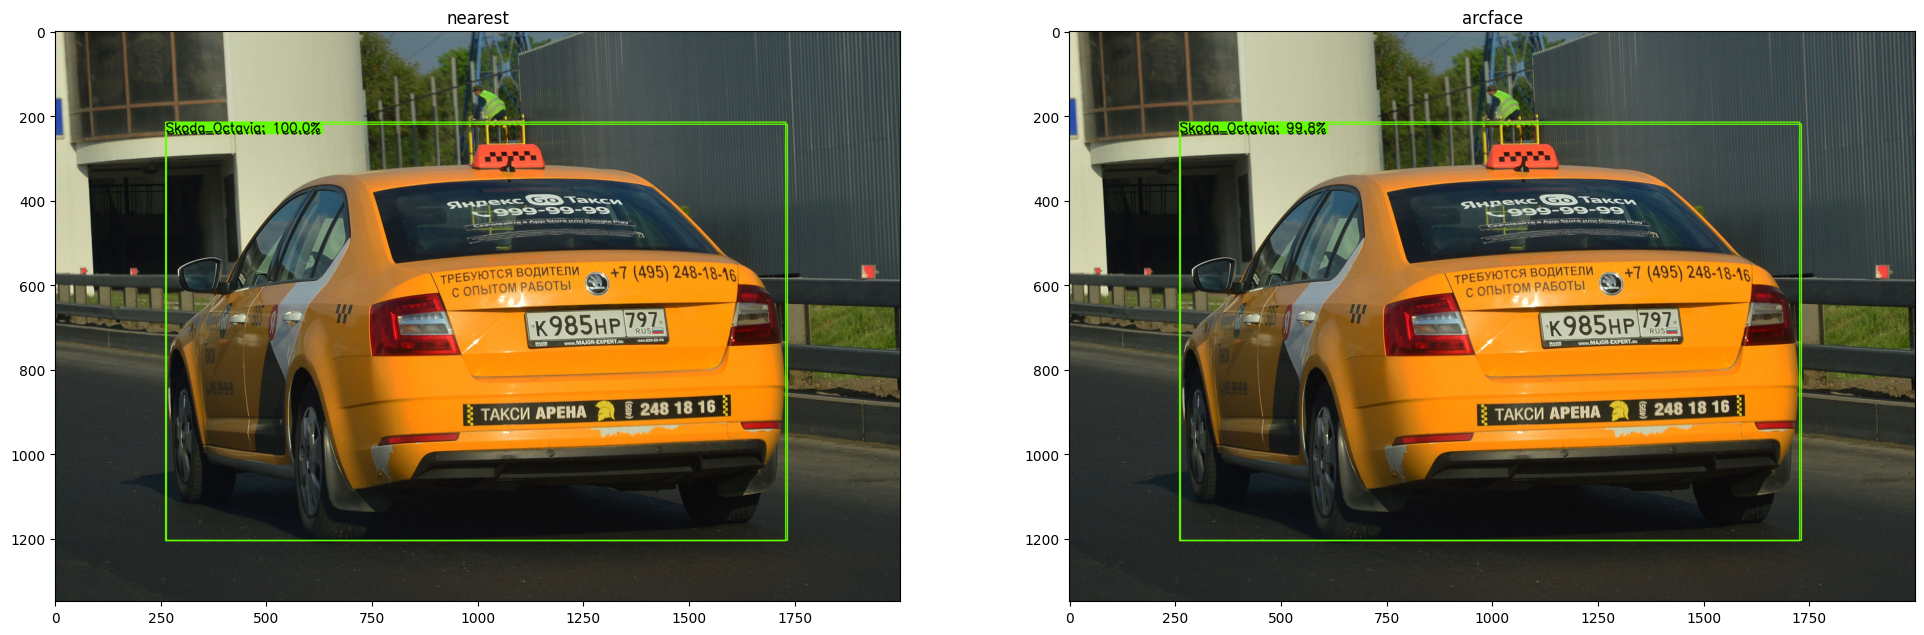

In [70]:
plot_prediction(prediction)